In [ ]:
from models.dataset import CustomDataset, tokenize_function
from models.gpt2_model import initialize_components
from models.tuned_lens import TunedLens
from scripts.train import train_loop
from scripts.evaluate import compute_perplexity_and_kl
from config.settings import Config
from utils.visualization import plot_kl_perplexity

import torch
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model, tuned_lens, tokenizer = initialize_components(device)
# Load dataset
dataset = load_dataset("agentlans/high-quality-english-sentences")

# Tokenize train and test data
train_data = dataset["train"].train_test_split(train_size=0.01)['train'].map(lambda batch: tokenize_function(tokenizer, batch), batched=True)

train_dataset = CustomDataset(train_data)

# Create optimized dataloader
dataloader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True
)

train_loop(dataloader, model, tuned_lens, device='cuda', verbose=False)

Map:   0%|          | 0/15346 [00:00<?, ? examples/s]

<ipython-input-18-1f64398f3077>:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=Config.mixed_precision)
  0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-18-1f64398f3077>:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast(enabled=Config.mixed_precision):
<ipython-input-18-1f64398f3077>:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=Config.mixed_precision):
Epoch 3 | Train Loss: 52.1847 | : 100%|██████████| 3/3 [45:51<00:00, 917.04s/it] 


In [ ]:
# Tokenize train and test data
test_data = dataset["test"].train_test_split(test_size=0.99)['train'].map(lambda batch: tokenize_function(tokenizer, batch), batched=True)

test_dataset = CustomDataset(test_data)

# Define dataloader
dataloader = DataLoader(
    test_dataset,
    batch_size=Config.batch_size,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True
)


avg_ppl_tuned, avg_kl_tuned, avg_ppl_logit, avg_kl_logit = compute_perplexity_and_kl(model, tokenizer, tuned_lens, dataloader, device, temperature=4.0)

Map:   0%|          | 0/1705 [00:00<?, ? examples/s]

Evaluating Tuned & Logit Lens:   0%|          | 0/107 [00:00<?, ?it/s]<ipython-input-57-a8b848bace8f>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Evaluating Tuned & Logit Lens: 100%|██████████| 107/107 [03:26<00:00,  1.93s/it]


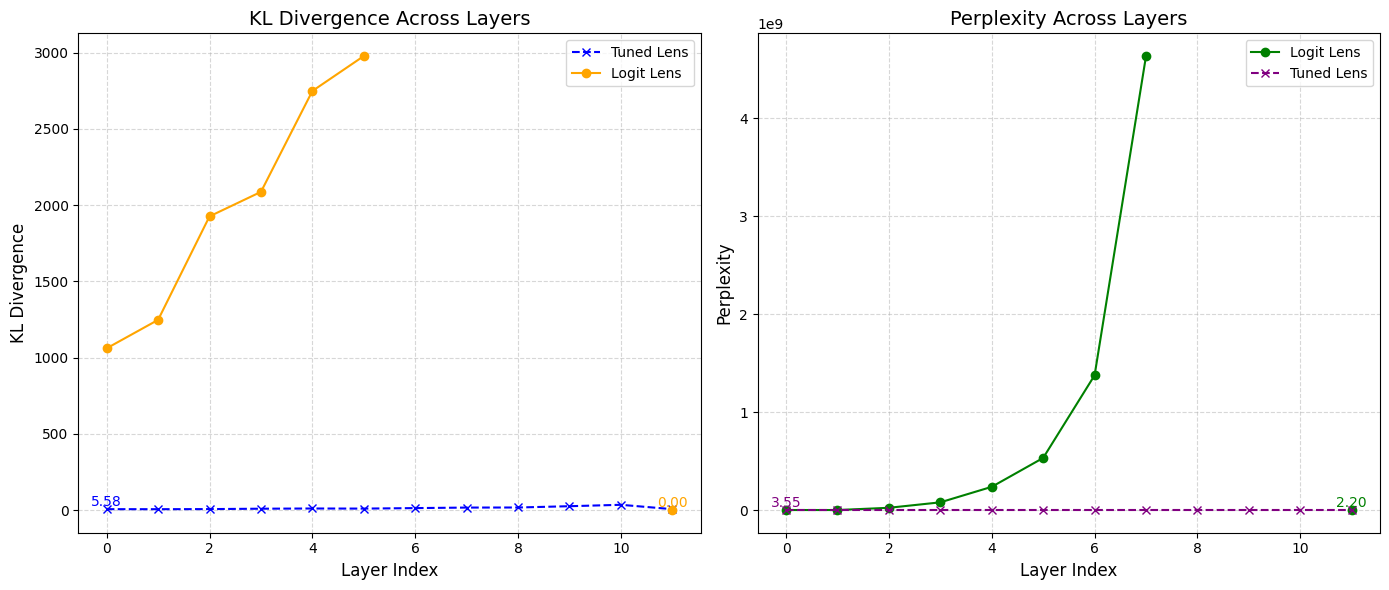

In [ ]:
plot_kl_perplexity(avg_ppl_tuned, avg_kl_tuned, avg_ppl_logit, avg_kl_logit)